# Reading data with coffea NanoEvents

This is a rendered copy of [nanoevents.ipynb](https://github.com/scikit-hep/coffea/blob/master/binder/nanoevents.ipynb). You can optionally run it interactively on [binder at this link](https://mybinder.org/v2/gh/coffeateam/coffea/master?filepath=binder%2Fnanoevents.ipynb)

NanoEvents is a Coffea utility to wrap flat nTuple structures (such as the CMS [NanoAOD](https://www.epj-conferences.org/articles/epjconf/pdf/2019/19/epjconf_chep2018_06021.pdf) format) into a single awkward array with appropriate object methods (such as Lorentz vector methods$^*$), cross references, and nested objects, all accessed in delayed$^\dagger$ mode from the source ROOT TTree via uproot. The interpretation of the TTree data is configurable via [schema objects](https://coffea-hep.readthedocs.io/en/latest/modules/coffea.nanoevents.html#classes), which are community-supplied  for various source file types. These schema objects allow a richer interpretation of the file contents than the `uproot` methods. Currently available schemas include:

   - `BaseSchema`, which provides a simple representation of the input TTree, where each branch is available verbatim as `events.branch_name`.  Any branches that uproot supports at "full speed" (i.e. that are fully split and either flat or single-jagged) can be read by this schema;
   - `NanoAODSchema`, which is optimized to provide all methods and cross-references in CMS NanoAOD format;
   - `PFNanoAODSchema`, which builds a double-jagged particle flow candidate colllection `events.jet.constituents` from compatible PFNanoAOD input files;
   - `TreeMakerSchema` which is designed to read TTrees made by [TreeMaker](https://github.com/TreeMaker/TreeMaker), an alternative CMS nTuplization format;
   - `PHYSLITESchema`, for the ATLAS DAOD_PHYSLITE derivation, a compact centrally-produced data format similar to CMS NanoAOD; and
   - `DelphesSchema`, for reading Delphes fast simulation [nTuples](https://cp3.irmp.ucl.ac.be/projects/delphes/wiki/WorkBook/RootTreeDescription).

We welcome contributions for new schemas, and can assist with the design of them.

$^*$ Vector methods are currently made possible via the [coffea vector](https://coffea-hep.readthedocs.io/en/latest/modules/coffea.nanoevents.methods.vector.html) methods mixin class structure. In a future version of coffea, they will instead be provided by the dedicated scikit-hep [vector](https://vector.readthedocs.io/en/latest/) library, which provides a more rich feature set. The coffea vector methods predate the release of the vector library.

$^\dagger$ _delayed_ access refers to only fetching the needed data from the (possibly remote) file when you're ready to compute the entire set of outputs. Until then, a minimal amount of metadata is used to trace the operations to eventually be performed (frequently called "lazily" "booking" operations in RDataFrame's approach to this)


In this demo, we will use NanoEvents to read a small CMS NanoAOD sample. The events object can be instantiated as follows:

In [1]:
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

NanoAODSchema.warn_missing_crossrefs = False

fname = "coffea/tests/samples/nano_dy.root"
access_log = []
events = NanoEventsFactory.from_root(
    {fname: "Events"},
    schemaclass=NanoAODSchema,
    metadata={"dataset": "DYJets"},
    mode="eager",
    access_log=access_log,
).events()

In the factory constructor, we also pass the desired schema version (the latest version of NanoAOD can be built with `schemaclass=NanoAODSchema`) for this file and some extra metadata that we can later access with `events.metadata`. In a later example, we will show how to set up this metadata in coffea processors where the `events` object is pre-created for you. Consider looking at the [from_root](https://coffea-hep.readthedocs.io/en/latest/api/coffea.nanoevents.NanoEventsFactory.html#coffea.nanoevents.NanoEventsFactory.from_root) class method to see all optional arguments.

The `events` object is an awkward array, which at its top level is a record array with one record for each "collection", where a collection is a grouping of fields (TBranches) based on the naming conventions of [NanoAODSchema](https://coffea-hep.readthedocs.io/en/latest/api/coffea.nanoevents.NanoAODSchema.html). For example, in the file we opened, the branches:
```
Generator_binvar
Generator_scalePDF
Generator_weight
Generator_x1
Generator_x2
Generator_xpdf1
Generator_xpdf2
Generator_id1
Generator_id2
```
are grouped into one sub-record named `Generator` which can be accessed using either getitem or getattr syntax, i.e. `events["Generator"]` or `events.Generator`. e.g.

In [2]:
events.Generator.id1

<Array [1, -1, -1, 21, 21, ..., -2, -1, 2, 1] type='40 * int32[parameters={...'>

In [3]:
# all names can be listed with:
events.Generator.fields

['binvar', 'scalePDF', 'weight', 'x1', 'x2', 'xpdf1', 'xpdf2', 'id1', 'id2']

In CMS NanoAOD, each TBranch has a self-documenting help string embedded in the title field, which is carried into the NanoEvents, e.g. executing the following cell should produce a help pop-up:
```
Type:            Array
String form:     [1, -1, -1, 21, 21, 4, 2, -2, 2, 1, 3, 1, ... -1, -1, 1, -2, 2, 1, 2, -2, -1, 2, 1]
Length:          40
File:            ~/src/awkward-1.0/awkward1/highlevel.py
Docstring:       id of first parton
Class docstring: ...
```
where the `Docstring` shows information about the content of this array.

In [4]:
events.Generator.id1?

Type:            Array
String form:     [1, -1, -1, 21, 21, 4, 2, -2, 2, 1, 3, ..., -1, 1, -2, 2, 1, 2, -2, -1, 2, 1]
Length:          40
File:            ~/Dropbox/work/pyhep_dev/awkward/src/awkward/highlevel.py
Docstring:       id of first parton
Class docstring:
Args:
    data (#ak.contents.Content, #ak.Array, `np.ndarray`, `cp.ndarray`, `pyarrow.*`, str, dict, or iterable):
        Data to wrap or convert into an array.
           - If a NumPy array, the regularity of its dimensions is preserved
             and the data are viewed, not copied.
           - CuPy arrays are treated the same way as NumPy arrays except that
             they default to `backend="cuda"`, rather than `backend="cpu"`.
           - If a pyarrow object, calls #ak.from_arrow, preserving as much
             metadata as possible, usually zero-copy.
           - If a dict of str → columns, combines the columns into an
             array of records (like Pandas's DataFrame constructor).
           - If a strin

Based on a collection's name or contents, some collections acquire additional _methods_, which are extra features exposed by the code in the mixin classes of the `coffea.nanoevents.methods` modules. For example, although `events.GenJet` has the fields:

In [5]:
events.GenJet.fields

['eta', 'mass', 'phi', 'pt', 'partonFlavour', 'hadronFlavour']

we can access additional attributes associated to each generated jet by virtue of the fact that they can be interpreted as [Lorentz vectors](https://coffea-hep.readthedocs.io/en/latest/api/coffea.nanoevents.methods.vector.LorentzVector.html#coffea.nanoevents.methods.vector.LorentzVector):

In [6]:
events.GenJet.energy

<Array [[217, 670, 258], [...], ..., [76.9]] type='40 * var * float32[param...'>

We can call more complex methods, like computing the distance $\Delta R = \sqrt{\Delta \eta^2 + \Delta \phi ^2}$ between two LorentzVector objects:

In [7]:
# find distance between leading jet and all electrons in each event
dr = events.Jet[:, 0].delta_r(events.Electron)
dr

<Array [[], [3.13], [3.45, ...], ..., [], []] type='40 * var * float32[para...'>

In [8]:
# find minimum distance
drmin = ak.min(dr, axis=1)
drmin

<Array [None, 3.13, 2.18, 1.58, ..., 0.0858, None, None] type='40 * ?float32'>

In [9]:
# a convenience method for this operation on all jets is available
events.Jet.nearest(events.Electron)

<ElectronArray [[None, None, ..., None, None], ...] type='40 * var * ?Elect...'>

The assignment of methods classes to collections is done inside the schema object during the initial creation of the array, governed by the awkward array's `__record__` parameter and the associated behavior. See [ak.behavior](https://awkward-array.readthedocs.io/en/latest/ak.behavior.html) for a more detailed explanation of array behaviors.

Additional methods provide convenience functions for interpreting some branches, e.g. CMS NanoAOD packs several jet identification flag bits into a single integer, `jetId`. By implementing the bit-twiddling in the [Jet mixin](https://github.com/CoffeaTeam/coffea/blob/7045c06b9448d2be4315e65d432e6d8bd117d6d7/coffea/nanoevents/methods/nanoaod.py#L279-L282), the analsyis code becomes more clear:

In [10]:
print(events.Jet.jetId)
print(events.Jet.isTight)

[[6, 6, 6, 6, 6], [6, 2, 6, 6, 6, 6, 6, 0], ..., [6, 6, 0, ..., 6, 6], [6, 6]]
[[True, True, True, True, True], [True, True, ..., False], ..., [True, True]]


We can also define convenience functions to unpack and apply some mask to a set of flags, e.g. for generated particles:

In [11]:
print(f"Raw status flags: {events.GenPart.statusFlags}")
events.GenPart.hasFlags(["isPrompt", "isLastCopy"])

Raw status flags: [[10625, 27009, 4481, 22913, 257, ..., 13884, 13884, 13884, 12876, 12876], ...]


<Array [[True, True, ..., False, False], ...] type='40 * var * bool[paramet...'>

CMS NanoAOD also contains pre-computed cross-references for some types of collections. For example, there is a TBranch `Electron_genPartIdx` which indexes the `GenPart` collection per event to give the matched generated particle, and `-1` if no match is found. NanoEvents transforms these indices into an awkward _indexed array_ pointing to the collection, so that one can directly access the matched particle using getattr syntax:

In [12]:
events.Electron.matched_gen.pdgId

<Array [[], [-11], [-11, 11], ..., [], []] type='40 * var * ?int32[paramete...'>

In [13]:
events.Muon[ak.num(events.Muon) > 0].matched_jet.pt

<Array [[84.4, 29.4], [31.1], ..., [25.8]] type='12 * var * ?float32[parame...'>

For generated particles, the parent index is similarly mapped:

In [14]:
events.GenPart.parent.pdgId

<Array [[None, None, 1, ..., 111, 111], ...] type='40 * var * ?int32[parame...'>

In addition, using the parent index, a helper method computes the inverse mapping, namely, `children`. As such, one can find particle siblings with:

In [15]:
events.GenPart.parent.children.pdgId
# notice this is a doubly-jagged array

<Array [[None, None, ..., [22, 22]], ...] type='40 * var * option[var * ?in...'>

Since often one wants to shortcut repeated particles in a decay sequence, a helper method `distinctParent` is also available. Here we use it to find the parent particle ID for all prompt electrons:

In [16]:
events.GenPart[(abs(events.GenPart.pdgId) == 11) & events.GenPart.hasFlags(["isPrompt", "isLastCopy"])].distinctParent.pdgId

<Array [[], [23, 23], [...], ..., [23, 23], []] type='40 * var * ?int32[par...'>

Events can be filtered like any other awkward array using boolean fancy-indexing

In [17]:
mmevents = events[ak.num(events.Muon) == 2]
zmm = mmevents.Muon[:, 0] + mmevents.Muon[:, 1]
zmm.mass

<Array [94.6, 87.6, 88, 90.4, 89.1, 31.6] type='6 * float32[parameters={"ty...'>

In [18]:
# a convenience method is available to sum vectors along an axis:
mmevents.Muon.sum(axis=1).mass

<Array [94.6, 87.6, 88, 90.4, 89.1, 31.6] type='6 * float32'>

As expected for this sample, most of the dimuon events have a pair invariant mass close to that of a Z boson. But what about the last event? Let's take a look at the generator information:

In [19]:
print(mmevents[-1].Muon.matched_gen.pdgId)
print(mmevents[-1].Muon.matched_gen.hasFlags(["isPrompt"]))

[-13, 13]
[False, False]


So they are real generated muons, but they are not prompt (i.e. from the initial decay of a heavy resonance)

Let's look at their parent particles:

In [20]:
mmevents[-1].Muon.matched_gen.parent.pdgId

<Array [-15, 15] type='2 * ?int32[parameters={"__doc__": "PDG id", "typenam...'>

aha! They are muons coming from tau lepton decays, and hence a fair amount of the Z mass is carried away by the neutrinos:

In [21]:
print(mmevents.Muon.matched_gen.sum().mass[-1])
print(mmevents.Muon.matched_gen.parent.sum().mass[-1])

31.265434
91.683304


One can assign new variables to the arrays, with some caveats:

 * Assignment must use setitem (`events["path", "to", "name"] = value`)
 * Assignment to a sliced `events` won't be accessible from the original variable
 * New variables are not visible from cross-references

In [22]:
mmevents["Electron", "myvariable"] = mmevents.Electron.pt + zmm.mass
mmevents.Electron.myvariable

<Array [[], [121], [], [], [], []] type='6 * var * float32[parameters={"typ...'>

## Virtual mode

NanoEvents supports reading lazily in "virtual" mode. In that mode, branches will only be loaded from the root file when an explicit computation needs them. This is the default mode of operation of NanoEvents and we will be using this moving forward.

In [23]:
fname = "coffea/tests/samples/nano_dy.root"
access_log = []
events = NanoEventsFactory.from_root(
    {fname: "Events"},
    schemaclass=NanoAODSchema,
    metadata={"dataset": "DYJets"},
    mode="virtual",
    access_log=access_log,
).events()

In [24]:
print(events.Jet.nearest(events.Electron))
print(access_log)

[[None, None, None, None, None], [Electron, Electron, ..., Electron], ..., [None, None]]
['nJet', 'nElectron', 'Jet_pt', 'Jet_phi', 'Jet_eta', 'Electron_pt', 'Electron_phi', 'Electron_eta']


In [25]:
events.Jet.jetId

<Array [??, ??, ??, ??, ..., ??, ??, ??, ??] type='40 * var * int32[paramet...'>

In [26]:
events.Jet.isTight

<Array [[True, True, ..., True, True], ...] type='40 * var * bool[parameter...'>

In [27]:
access_log

['nJet',
 'nElectron',
 'Jet_pt',
 'Jet_phi',
 'Jet_eta',
 'Electron_pt',
 'Electron_phi',
 'Electron_eta',
 'Jet_jetId']

In [28]:
events.Jet.jetId

<Array [[6, 6, 6, 6, 6], [6, ...], ..., [6, 6]] type='40 * var * int32[para...'>

In [29]:
mmevents = events[ak.num(events.Muon) == 2]
zmm = mmevents.Muon[:, 0] + mmevents.Muon[:, 1]
zmm.mass

<Array [94.6, 87.6, 88, 90.4, 89.1, 31.6] type='6 * float32[parameters={"ty...'>

In [30]:
access_log

['nJet',
 'nElectron',
 'Jet_pt',
 'Jet_phi',
 'Jet_eta',
 'Electron_pt',
 'Electron_phi',
 'Electron_eta',
 'Jet_jetId',
 'nMuon',
 'Muon_pt',
 'Muon_phi',
 'Muon_eta',
 'Muon_mass',
 'Muon_charge']

The `access_log` keeps track of the branch we load in a time-ordered manner. Notice how after every cell above, only the branches that are actually required to evaluate that cell are loaded.

## Dask mode

Finally, NanoEvents supports "dask" mode. In that mode, the whole `events` object is a lazy `dask-awkward` (https://dask-awkward.readthedocs.io/en/stable/#) array. All the operations create a computational graph of "to be evaluated" steps that actually only run when `compute` gets called. Feel free to read about `dask` and `dask.array` too to understand general concepts of how it works.

In [31]:
import dask

fname = "coffea/tests/samples/nano_dy.root"
events = NanoEventsFactory.from_root(
    {fname: "Events"},
    schemaclass=NanoAODSchema,
    metadata={"dataset": "DYJets"},
    mode="dask",
).events()

In [32]:
events.Jet.nearest(events.Electron)

dask.awkward<firsts, type='## * var * ?Electron', npartitions=1>

In [33]:
a, b = dask.compute(events.Jet.jetId, events.Jet.isTight)
print(a)
print(b)

[[6, 6, 6, 6, 6], [6, 2, 6, 6, 6, 6, 6, 0], ..., [6, 6, 0, ..., 6, 6], [6, 6]]
[[True, True, True, True, True], [True, True, ..., False], ..., [True, True]]


In [34]:
mmevents = events[ak.num(events.Muon) == 2]
zmm = mmevents.Muon[:, 0] + mmevents.Muon[:, 1]
zmm_mass = zmm.mass

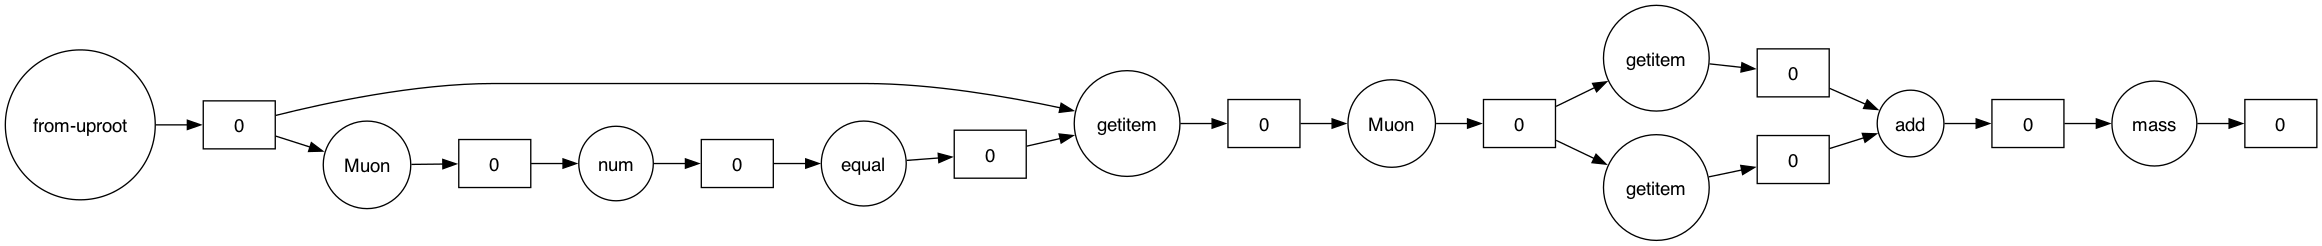

In [35]:
zmm_mass.visualize(rankdir="LR", optimize_graph=False)

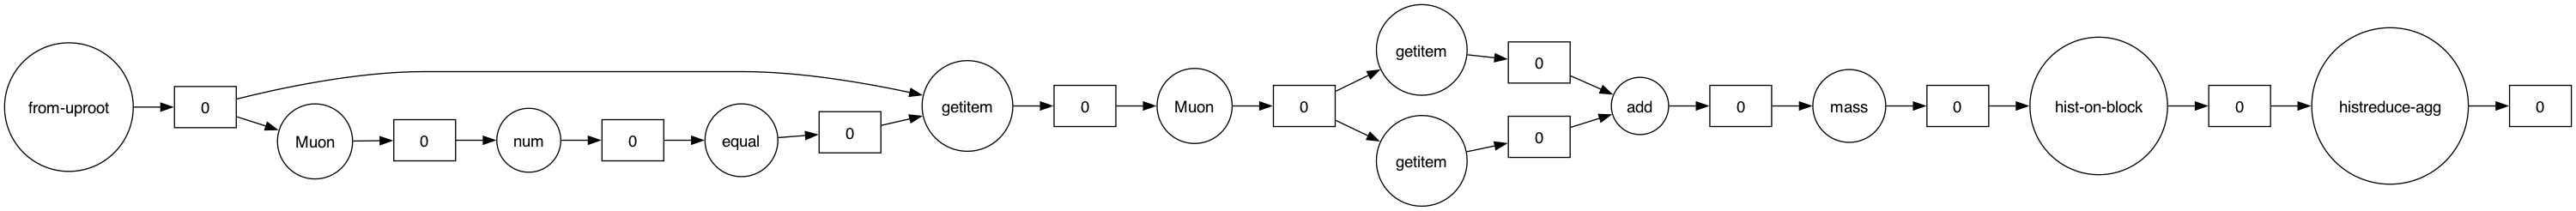

In [36]:
from hist.dask import Hist

h = Hist.new.Reg(4, 80, 100).Double().fill(zmm_mass)
h.visualize(rankdir="LR", optimize_graph=False)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x148cad160>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

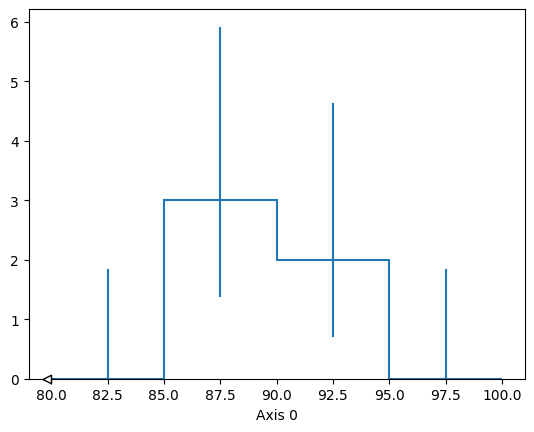

In [37]:
h.compute().plot()